# Wstęp do uczenia maszynowego - PD1

## 1. Eksploracyjna analiza danych
W pierszej kolejności przyjrzyjmy się danym, na których później będziemy modelować.

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     StratifiedKFold)
from sklearn.metrics import (roc_auc_score, classification_report,
                             confusion_matrix, roc_curve,
                             precision_score, recall_score, f1_score)
from sklearn.tree import DecisionTreeClassifier, plot_tree

sns.set(style='darkgrid')

import warnings
warnings.filterwarnings('ignore')

NR_INDEKSU = 327217

In [2]:
# Reading data
X = pd.read_csv('X.csv', index_col=0)
y = pd.read_csv('y.csv', index_col=0)
y.columns = ['target']

# Combining data into one data frame for easier exploration
df = pd.concat([X, y], axis=1)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,target
0,2.504280,1.165802,2.567506,-0.399940,1.008110,2.379108,0.991698,0.563444,0.0
1,-2.201358,0.887550,0.872891,2.023147,-1.711817,-1.637994,1.143967,-0.743122,0.0
2,2.233496,0.464743,3.470472,-1.888077,-2.610473,0.301459,1.742215,1.515108,0.0
3,-1.311672,-0.768893,-2.615540,-1.522393,0.381070,-1.245576,-1.837726,1.617176,1.0
4,-0.562231,1.267943,1.603228,1.166734,-0.399512,-0.091997,1.149495,1.031725,0.0


In [4]:
df.describe()

,0,1,2,3,4,5,6,7,target
count,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,946.000000
mean,-0.016634,0.009323,0.394778,0.541488,-0.995397,0.091138,-0.014405,-0.067722,0.497886
std,1.550788,1.485657,2.274194,1.689062,1.430075,1.917017,1.651510,1.017954,0.500260
min,-5.634847,-4.491813,-6.399191,-3.807665,-7.573028,-4.938971,-5.370469,-5.188007,0.000000
25%,-1.080786,-1.068714,-1.237993,-0.712260,-1.954813,-1.302972,-1.027901,-0.730426,0.000000
50%,0.127341,-0.122176,0.397683,0.657789,-0.970469,0.046226,0.290657,-0.078105,0.000000
75%,1.143570,1.077955,2.122202,1.617422,-0.003298,1.425184,1.144729,0.627713,1.000000
max,7.304825,5.482399,16.040589,5.528257,3.110177,5.591951,8.349125,3.232800,1.000000


Widzimy, że wszystkie zmienne są numeryczne i ciągłe.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 949 entries, 0 to 948
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       949 non-null    float64
 1   1       949 non-null    float64
 2   2       949 non-null    float64
 3   3       949 non-null    float64
 4   4       949 non-null    float64
 5   5       949 non-null    float64
 6   6       949 non-null    float64
 7   7       949 non-null    float64
 8   target  946 non-null    float64
dtypes: float64(9)
memory usage: 74.1 KB


Widzimy, że w zmiennej celu mamy 3 brakujące wartości, najprawdopodobniej usuniemy te wiersze z danych. Sprawdźmy teraz jej rozkład.

Text(0, 0.5, 'Liczność')

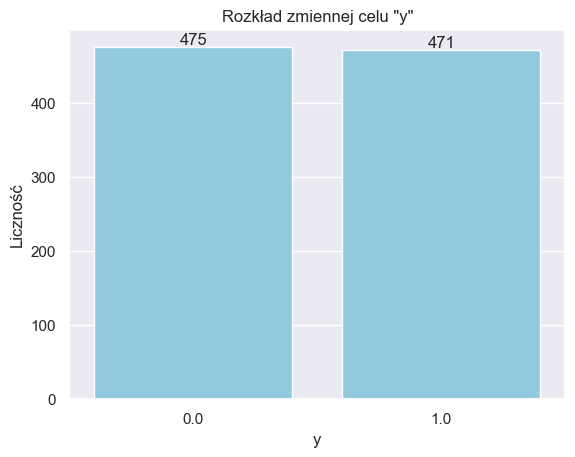

In [6]:
ax = sns.countplot(data=df, x='target', color='skyblue')
ax.bar_label(ax.containers[0])
ax.set_title('Rozkład zmiennej celu "y"')
ax.set_xlabel('y')
ax.set_ylabel('Liczność')

Widzimy, że nasz zbiór jest praktycznie perfekcyjnie zbalansowany, co jest świetną informacją przed modelowaniem.

Przyjrzyjmy się teraz rozkładom pozostałych zmiennych.

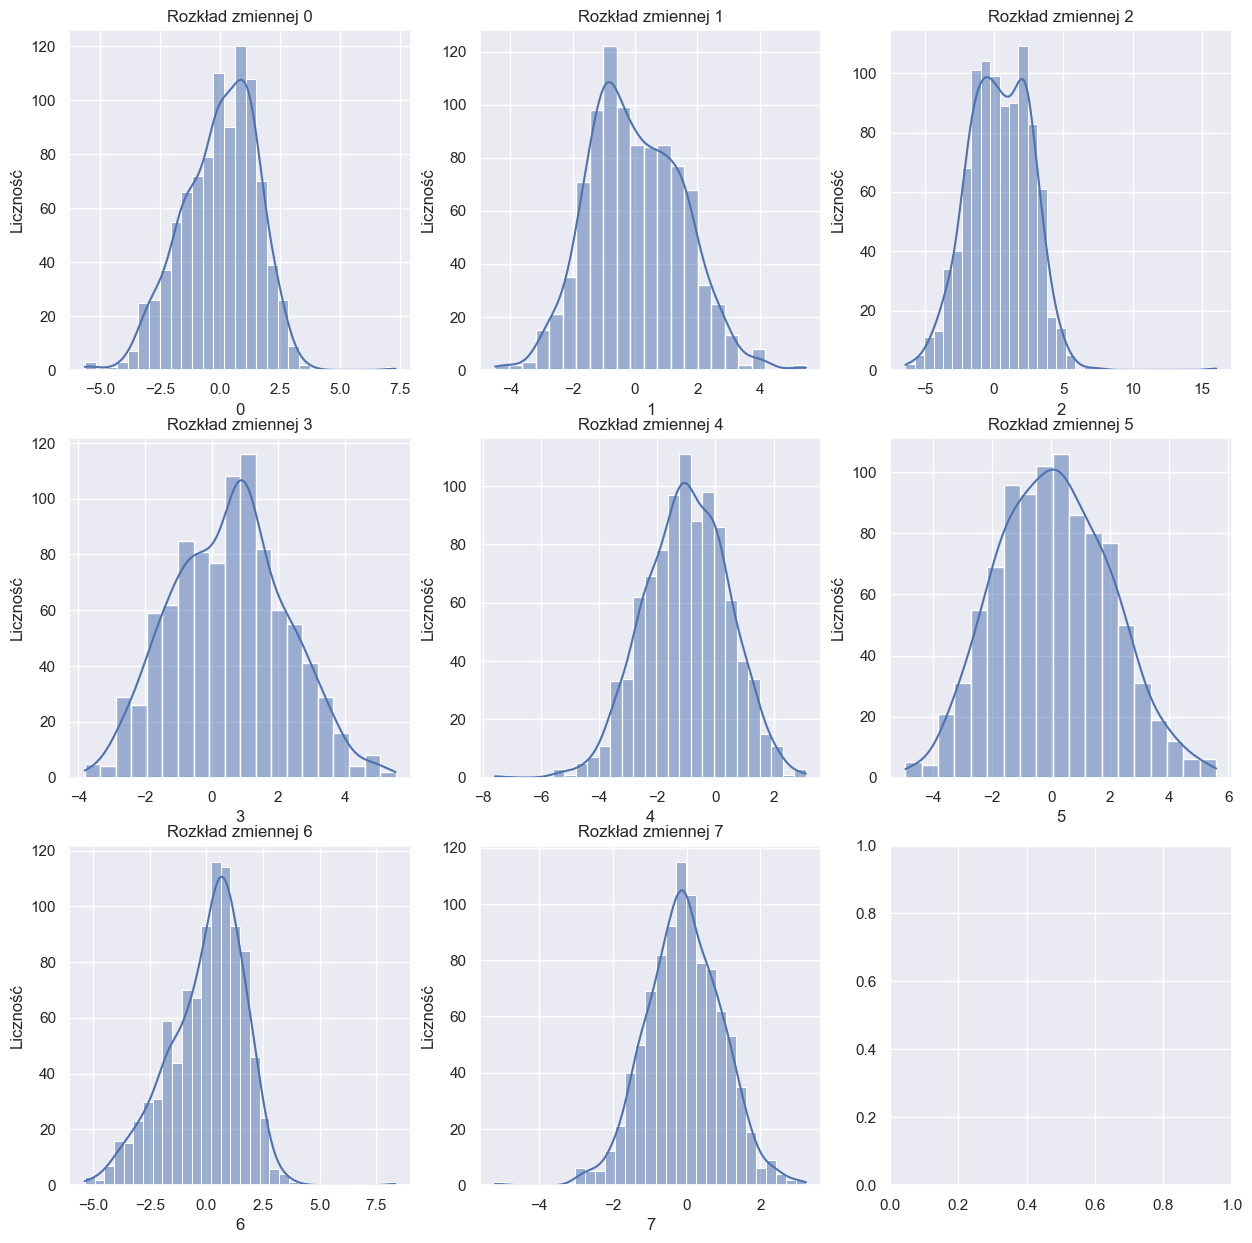

In [7]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(8):
    sns.histplot(data=df, x=df.columns[i], ax=ax[i//3, i%3], kde=True)
    ax[i//3, i%3].set_title(f'Rozkład zmiennej {df.columns[i]}')
    ax[i//3, i%3].set_xlabel(df.columns[i])
    ax[i//3, i%3].set_ylabel('Liczność')

Sprawdźmy też korelacje między zmiennymi, oraz czy zmienna celu ma na nią wpływ.

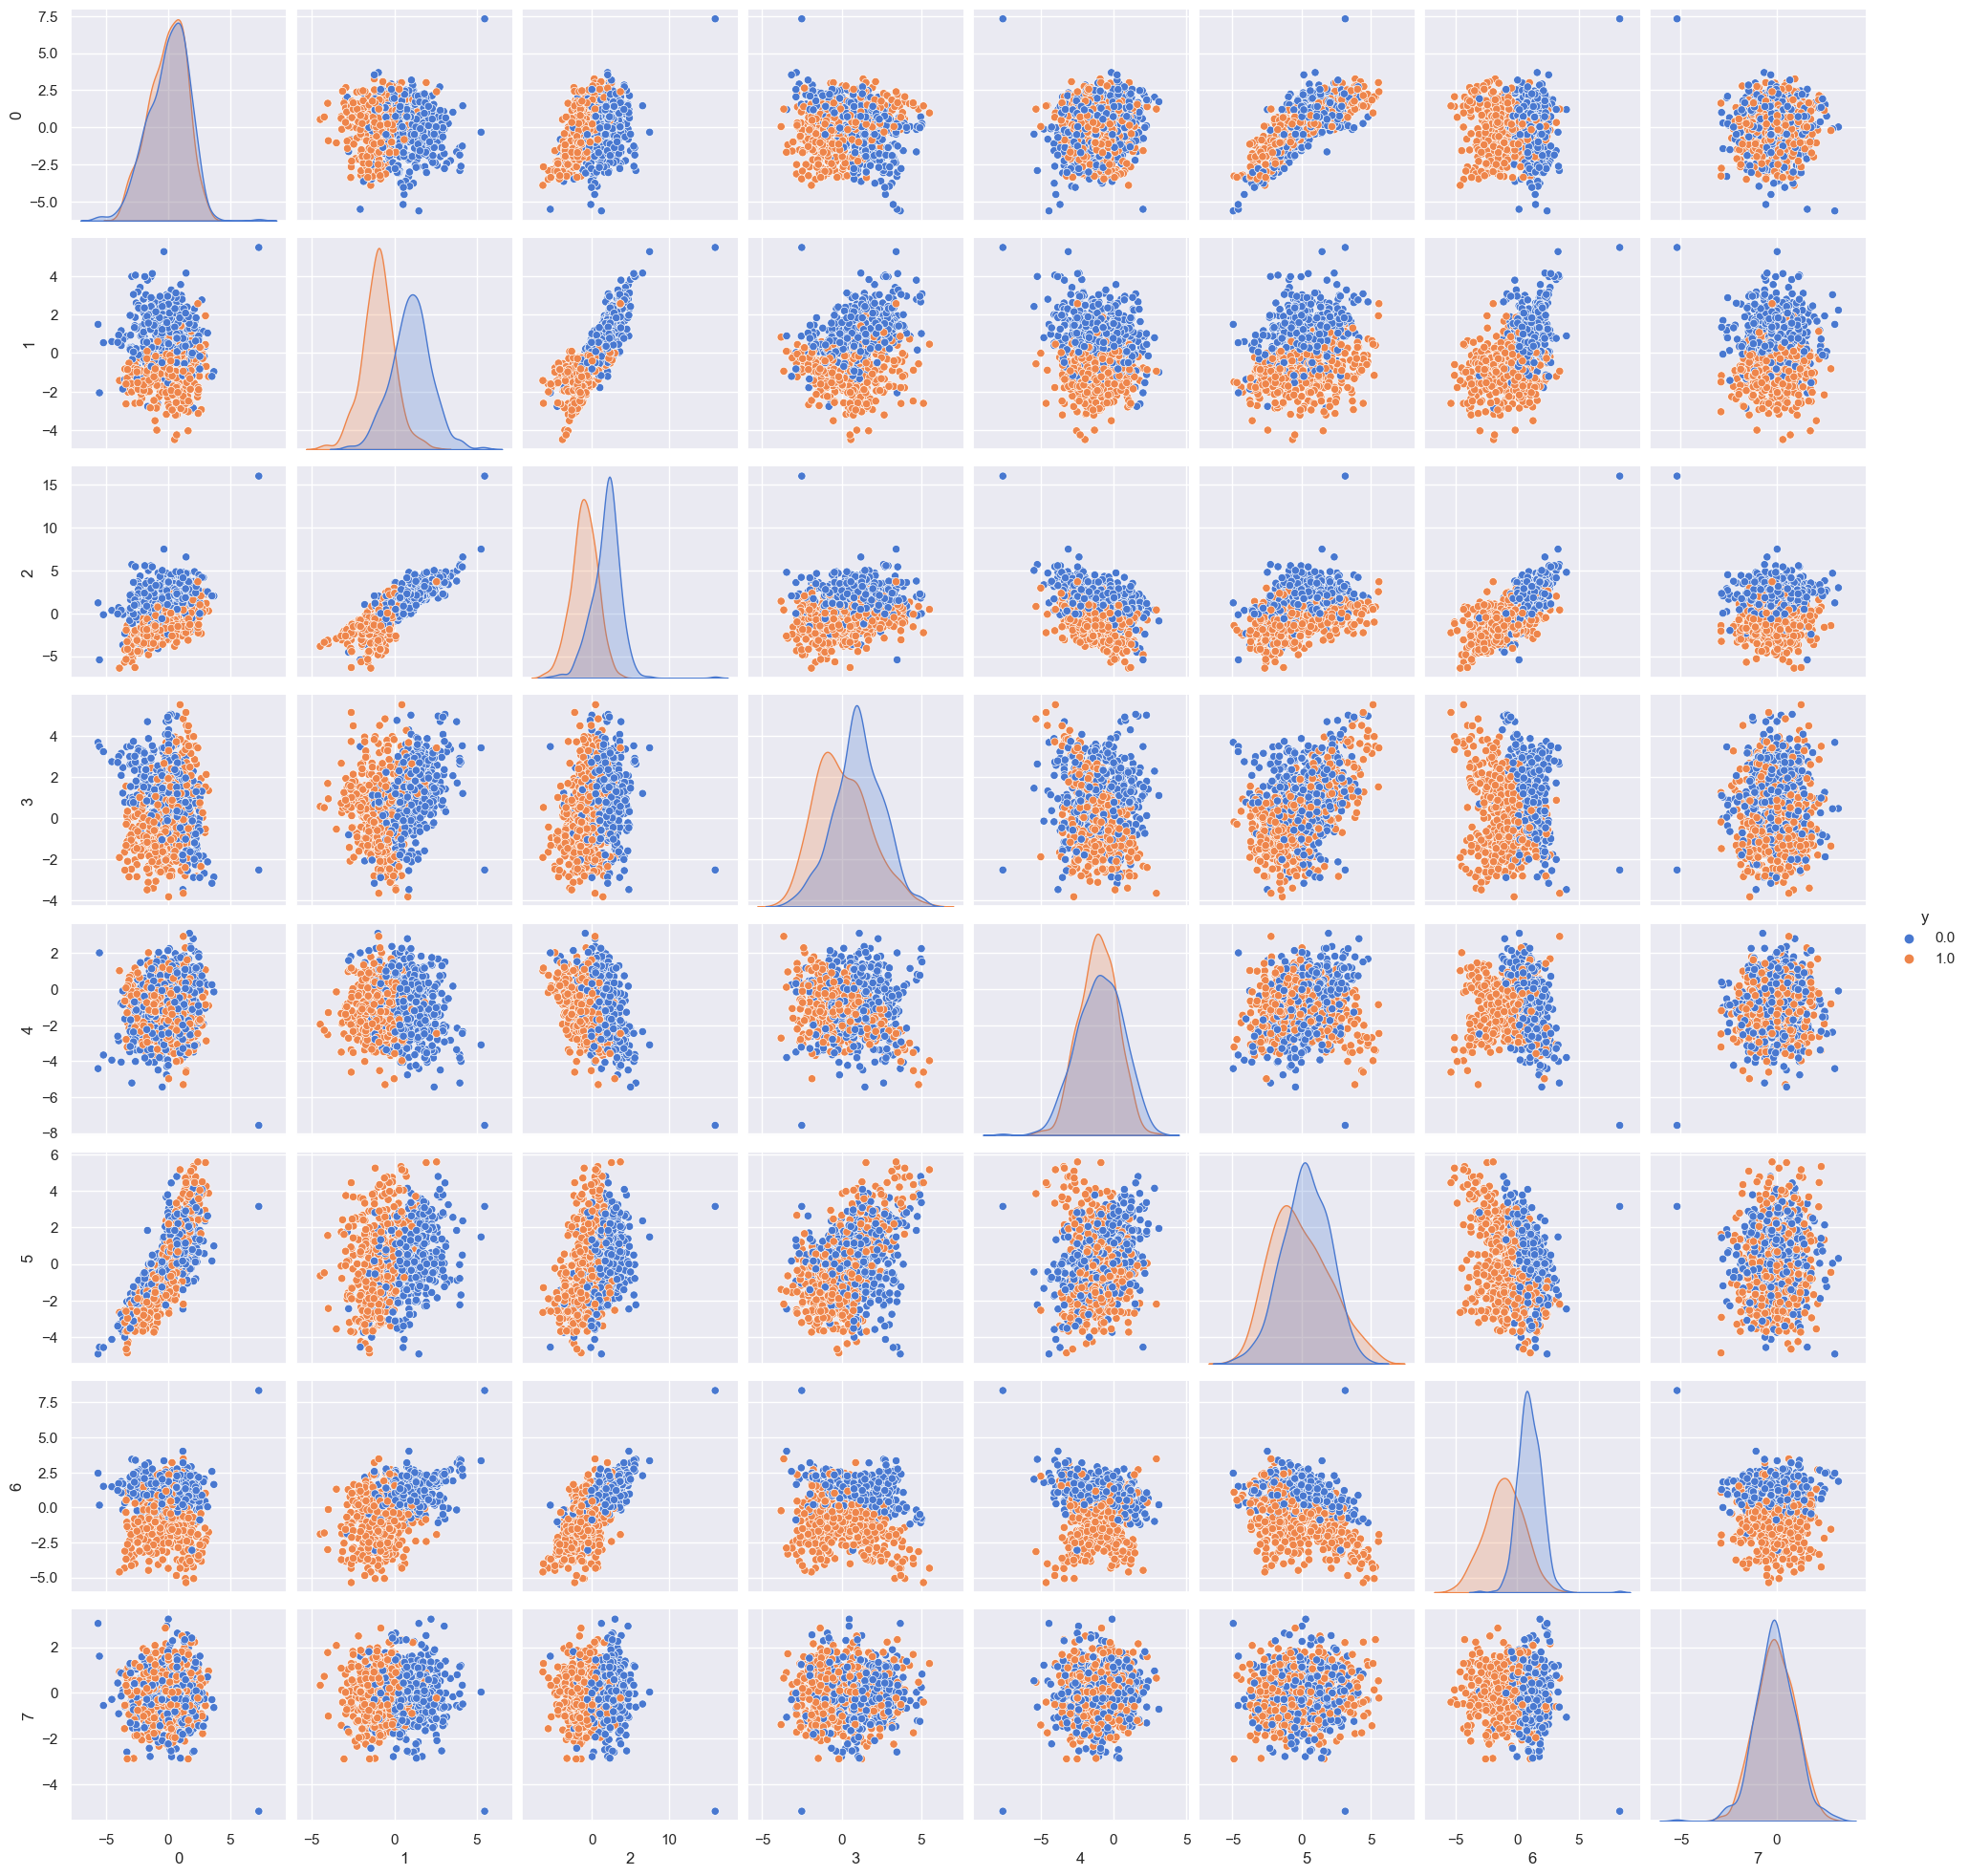

In [8]:
ax = sns.pairplot(df, hue='target', palette='muted')
ax.legend.set_title('y')

Możemy zauważyć, że niektóre zmienne bardzo dobrze rozdzielają obserwacje z różnych klas, a inne nie mają tak dużego wpływu.

## 2. Przygotowanie danych

In [9]:
# Get index of missing values
missing = y[y.isnull().any(axis=1)].index

# Drop missing values
X = X.drop(missing)
y = y.drop(missing)

# Check if missing values are dropped
X.shape, y.shape, X.isnull().sum().sum(), y.isnull().sum().sum()

((946, 8), (946, 1), 0, 0)

In [10]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=NR_INDEKSU)

## 3. Eksperyment

In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=NR_INDEKSU)

criterion = ['gini', 'entropy']
max_depth = range(3, 9)
min_samples_leaf = range(4, 17, 2)
max_leaf_nodes = range(8, 29, 4)

results = pd.DataFrame(columns=['Criterion', 'Depth', 'Min samples/leaf', 'Max leaf nodes', 'AUC Score train (mean)', 'AUC Score test'])

for crit in criterion:
    for depth in max_depth:
        for n_samples in min_samples_leaf:
            for leaf_nodes in max_leaf_nodes:
                model = DecisionTreeClassifier(criterion=crit, max_depth=depth, min_samples_leaf=n_samples,
                                               max_leaf_nodes=leaf_nodes, random_state=NR_INDEKSU)
                model.fit(X_train, y_train)
                train_score = np.round(cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv).mean(), 3)
                test_score = np.round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]), 3)
                results = pd.concat([results, pd.DataFrame([[crit, depth, n_samples, leaf_nodes, train_score, test_score]],
                                                            columns=results.columns)])

results = results.reset_index(drop=True)
results.head(10)

,Criterion,Depth,Min samples/leaf,Max leaf nodes,AUC Score train (mean),AUC Score test
0,gini,3,4,8,0.919,0.948
1,gini,3,4,12,0.919,0.948
2,gini,3,4,16,0.919,0.948
3,gini,3,4,20,0.919,0.948
4,gini,3,4,24,0.919,0.948
5,gini,3,4,28,0.919,0.948
6,gini,3,6,8,0.920,0.950
7,gini,3,6,12,0.920,0.950
8,gini,3,6,16,0.920,0.950
9,gini,3,6,20,0.920,0.950


Zobaczmy dla jakich zestawów hiperparametrów nasz model działa najlepiej.

In [12]:
results.sort_values(by='AUC Score test', ascending=False).head(10)

,Criterion,Depth,Min samples/leaf,Max leaf nodes,AUC Score train (mean),AUC Score test
335,entropy,4,16,28,0.927,0.962
332,entropy,4,16,16,0.927,0.962
333,entropy,4,16,20,0.927,0.962
334,entropy,4,16,24,0.927,0.962
326,entropy,4,14,16,0.932,0.957
327,entropy,4,14,20,0.932,0.957
328,entropy,4,14,24,0.932,0.957
329,entropy,4,14,28,0.932,0.957
331,entropy,4,16,12,0.927,0.957
416,entropy,6,16,16,0.928,0.956


In [13]:
results.sort_values(by='AUC Score train (mean)', ascending=False).head(10)

,Criterion,Depth,Min samples/leaf,Max leaf nodes,AUC Score train (mean),AUC Score test
353,entropy,5,8,28,0.933,0.945
371,entropy,5,14,28,0.933,0.950
411,entropy,6,14,20,0.933,0.945
412,entropy,6,14,24,0.933,0.945
413,entropy,6,14,28,0.933,0.945
370,entropy,5,14,24,0.933,0.950
369,entropy,5,14,20,0.933,0.950
368,entropy,5,14,16,0.933,0.956
351,entropy,5,8,20,0.933,0.945
352,entropy,5,8,24,0.933,0.945


Jak performens modelu zależy od wartości hiperparametrów?

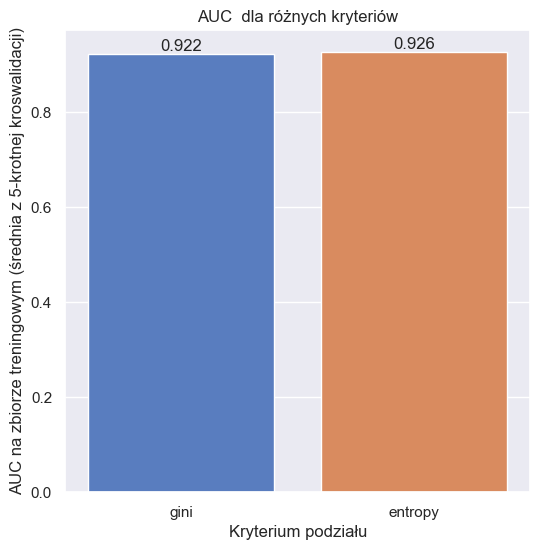

In [14]:
plt.figure(figsize=(6, 6))
ax = sns.barplot(data=results, x='Criterion', y='AUC Score train (mean)', palette='muted', ci=None)
ax.bar_label(ax.containers[0], fmt='%.3f')
plt.title('AUC  dla różnych kryteriów')
plt.xlabel('Kryterium podziału')
plt.ylabel('AUC na zbiorze treningowym (średnia z 5-krotnej kroswalidacji)')
plt.show()

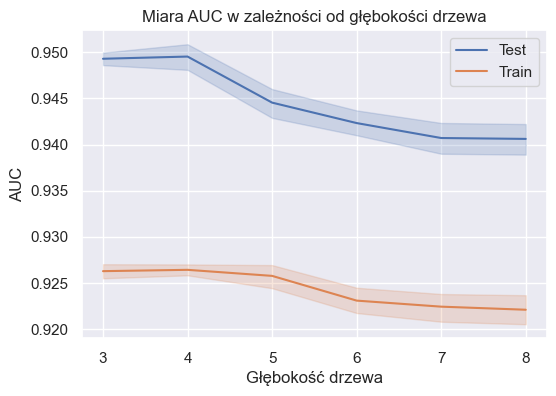

In [25]:
plt.figure(figsize=(6, 4))
sns.lineplot(data=results, x='Depth', y='AUC Score test', label='Test')
sns.lineplot(data=results, x='Depth', y='AUC Score train (mean)', label='Train')
plt.title('Miara AUC w zależności od głębokości drzewa')
plt.xlabel('Głębokość drzewa')
plt.ylabel('AUC')
plt.show()

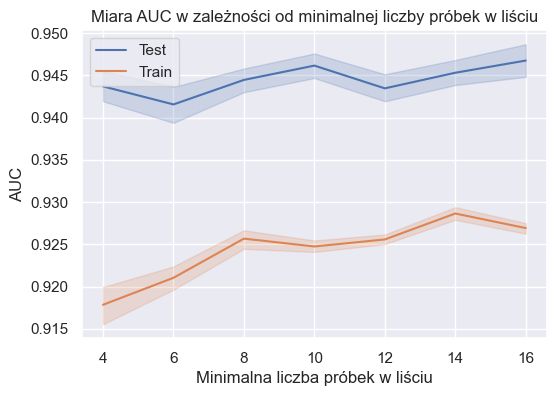

In [26]:
plt.figure(figsize=(6, 4))
sns.lineplot(data=results, x='Min samples/leaf', y='AUC Score test', label='Test')
sns.lineplot(data=results, x='Min samples/leaf', y='AUC Score train (mean)', label='Train')
plt.title('Miara AUC w zależności od minimalnej liczby próbek w liściu')
plt.xlabel('Minimalna liczba próbek w liściu')
plt.ylabel('AUC')
plt.show()

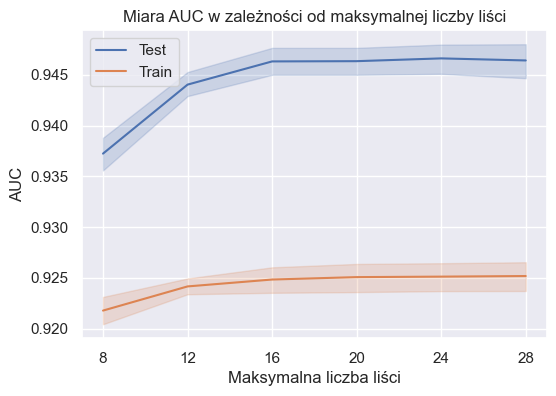

In [28]:
plt.figure(figsize=(6, 4))
sns.lineplot(data=results, x='Max leaf nodes', y='AUC Score test', label='Test')
sns.lineplot(data=results, x='Max leaf nodes', y='AUC Score train (mean)', label='Train')
plt.title('Miara AUC w zależności od maksymalnej liczby liści')
plt.xticks(range(8, 29, 4))
plt.xlabel('Maksymalna liczba liści')
plt.ylabel('AUC')
plt.show()

## 4. Wybór najlepszego modelu

In [18]:
BEST_MAX_DEPTH = 5
BEST_MIN_SAMPLES_LEAF = 8
BEST_MAX_LEAF_NODES = 20
BEST_CRITERION = 'entropy'

model = DecisionTreeClassifier(criterion=BEST_CRITERION, max_depth=BEST_MAX_DEPTH,
                               min_samples_leaf=BEST_MIN_SAMPLES_LEAF, max_leaf_nodes=BEST_MAX_LEAF_NODES,
                               random_state=NR_INDEKSU)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

Sprawdźmy, jak wygląda struktura naszego drzewa.

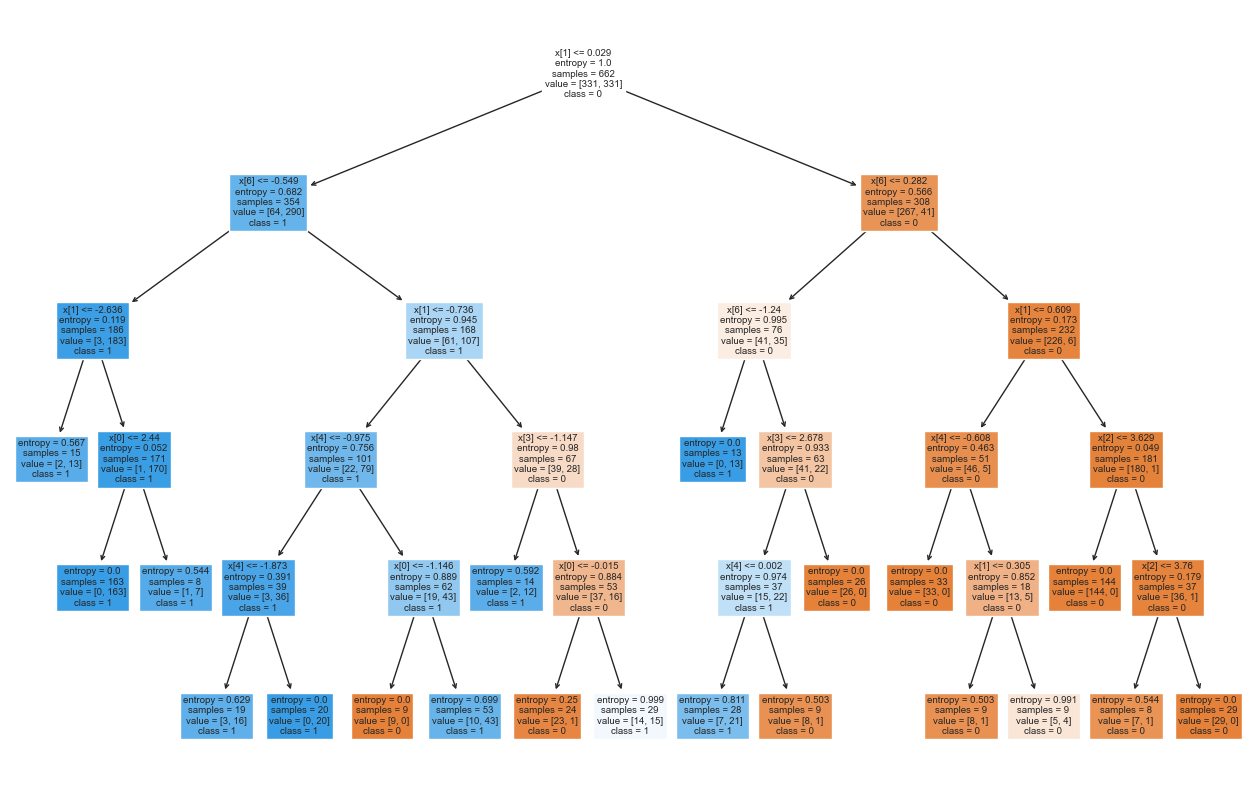

In [19]:
plt.figure(figsize=(16, 10))
plot_tree(model, filled=True, class_names=['0', '1'])
plt.show()

In [20]:
print(f"Metryki dla danych testowych:\n{classification_report(y_test, y_pred_test)}")
print(f"Metryki dla danych treningowych:\n{classification_report(y_train, y_pred_train)}")    

Metryki dla danych testowych:
              precision    recall  f1-score   support

         0.0       0.94      0.84      0.89       144
         1.0       0.85      0.94      0.89       140

    accuracy                           0.89       284
   macro avg       0.89      0.89      0.89       284
weighted avg       0.90      0.89      0.89       284

Metryki dla danych treningowych:
              precision    recall  f1-score   support

         0.0       0.97      0.88      0.93       331
         1.0       0.89      0.98      0.93       331

    accuracy                           0.93       662
   macro avg       0.93      0.93      0.93       662
weighted avg       0.93      0.93      0.93       662



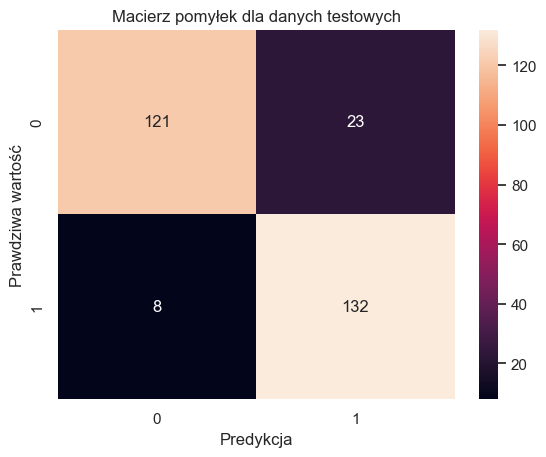

In [21]:
plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d')
plt.title('Macierz pomyłek dla danych testowych')
plt.xlabel('Predykcja')
plt.ylabel('Prawdziwa wartość')
plt.show()

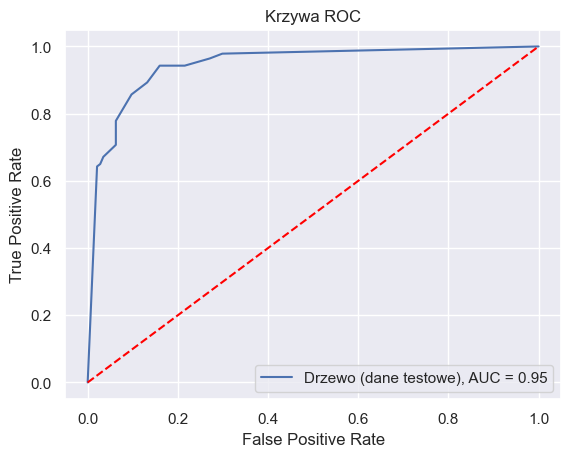

In [22]:
# Draw roc curve
plt.figure()
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='Drzewo (dane testowe), AUC = ' + str(round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]), 2)))
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.title('Krzywa ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## 5. Czy wielkość próbki uczącej ma wpływ na jakość modelu?

In [23]:
sample_size = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
results2 = pd.DataFrame(columns=['Sample size [%]', 'Accuracy', 'Recall', 'Precision', 'F1', 'ROC AUC'])

for size in sample_size:
    model = DecisionTreeClassifier(criterion=BEST_CRITERION, max_depth=BEST_MAX_DEPTH,
                                   min_samples_leaf=BEST_MIN_SAMPLES_LEAF, max_leaf_nodes=BEST_MAX_LEAF_NODES,
                                   random_state=NR_INDEKSU)
    data_sample = pd.concat([X_train, y_train], axis=1).sample(frac=size, random_state=NR_INDEKSU)
    X = data_sample.drop('target', axis=1)
    y = data_sample['target']

    model.fit(X, y)
    y_pred = model.predict(X_test)
    results2 = pd.concat([results2, pd.DataFrame([[size*100, 
                                                 model.score(X_test, y_test),
                                                 recall_score(y_test, y_pred),
                                                 precision_score(y_test, y_pred),
                                                 f1_score(y_test, y_pred),
                                                 roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])]],
                                                 columns=results2.columns)])

results2 = results2.reset_index(drop=True)
results2

,Sample size [%],Accuracy,Recall,Precision,F1,ROC AUC
0,5.0,0.816901,0.742857,0.866667,0.800000,0.818254
1,10.0,0.795775,0.685714,0.872727,0.768000,0.869940
2,25.0,0.887324,0.964286,0.833333,0.894040,0.921652
3,50.0,0.890845,0.900000,0.881119,0.890459,0.906498
4,75.0,0.880282,0.871429,0.884058,0.877698,0.938467
5,90.0,0.894366,0.885714,0.898551,0.892086,0.962202
6,95.0,0.894366,0.892857,0.892857,0.892857,0.959697


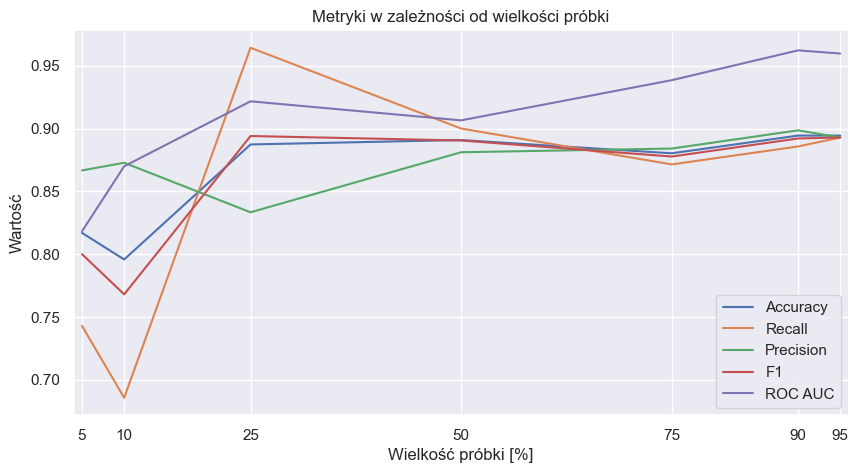

In [24]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=results2, x='Sample size [%]', y='Accuracy', label='Accuracy')
sns.lineplot(data=results2, x='Sample size [%]', y='Recall', label='Recall')
sns.lineplot(data=results2, x='Sample size [%]', y='Precision', label='Precision')
sns.lineplot(data=results2, x='Sample size [%]', y='F1', label='F1')
sns.lineplot(data=results2, x='Sample size [%]', y='ROC AUC', label='ROC AUC')
plt.xlim(4, 96)
plt.xticks([5, 10, 25, 50, 75, 90, 95])
plt.title('Metryki w zależności od wielkości próbki')
plt.xlabel('Wielkość próbki [%]')
plt.ylabel('Wartość')
plt.show()